Основные характеристики

Источник данных:
The Investors Exchange (IEX) API

Период:
5 лет исторических данных (примерно 2013-2018)
Последнее обновление: февраль 2018

Охват компаний:
Все компании из индекса S&P 500
505 компаний 

Структура данных

Колонка  Тип данных  Описание  
Date     Дата        Дата торгов в формате ГГГГ-ММ-ДД  2013-02-08
Open     Число       Цена открытия (USD)  15.07
High     Число       Максимальная цена дня (USD)  15.12
Low      Число       Минимальная цена дня (USD)  14.63
Close    Число       Цена закрытия (USD)  14.75
Volume   Целое       Количество проданных акций  8,407,500
Name     Строка      Тикер акции  AAL

In [1]:
!pip install pyspark

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Economic Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

25/06/01 10:15:42 WARN Utils: Your hostname, devopsvm resolves to a loopback address: 127.0.1.1; using 192.168.111.198 instead (on interface enp0s3)
25/06/01 10:15:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 10:15:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, LongType

# 1. Чтение данных
data = spark.read.option("header", "true").csv("hdfs://localhost:9000/3_zadanie/hadoop/input/all_stocks_5yr.csv")

Данный график был объединен с графиками по скользящим средним. Скользящие средние сглаживают ценовые колебания, что помогает определить тренды. Для анализа краткосрочных трендов я построила 10-дневную SMA, а для долгосрочных трендов 50-дневная.

In [5]:
print(data.dtypes)

[('date', 'string'), ('open', 'string'), ('high', 'string'), ('low', 'string'), ('close', 'string'), ('volume', 'string'), ('Name', 'string')]


Надо поменять тип даты на дату, а также данные со стоимостью привести к числовому виду, только Name оставить неизменным.

In [4]:
dataTyped = data.select(
    F.to_date("date", "yyyy-MM-dd").alias("date"),
    data["open"].cast(DoubleType()).alias("open"),
    data["high"].cast(DoubleType()).alias("high"),
    data["low"].cast(DoubleType()).alias("low"),
    data["close"].cast(DoubleType()).alias("close"),
    F.regexp_replace(data["volume"], ",", "").cast(LongType()).alias("volume"),
    data["Name"]
)

print(dataTyped.dtypes)

[('date', 'date'), ('open', 'double'), ('high', 'double'), ('low', 'double'), ('close', 'double'), ('volume', 'bigint'), ('Name', 'string')]


Все типы данных исходного файла в порядке. Далее был осуществлен поиск дубликатов и проведена описательная статистика.

In [8]:
from pyspark.sql import functions as F

duplicates = dataTyped.groupBy(dataTyped.columns).agg(F.count("*").alias("cnt")).filter(F.col("cnt") > 1)
duplicates.show()

+----+----+----+---+-----+------+----+---+
|date|open|high|low|close|volume|Name|cnt|
+----+----+----+---+-----+------+----+---+
+----+----+----+---+-----+------+----+---+



Дублей нет.

In [9]:
descriptive_stats = dataTyped.describe()
descriptive_stats.show()

25/05/31 22:19:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------+
|summary|             open|             high|              low|            close|           volume|  Name|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------+
|  count|           619029|           619032|           619032|           619040|           619040|619040|
|   mean|83.02333431454696|83.77831069346465|82.25609641375786|83.04376276476573|4321823.395568945|  NULL|
| stddev| 97.3787690433231|  98.207518904464| 96.5074210580914|97.38974800165752|8693609.511967659|  NULL|
|    min|             1.62|             1.69|              1.5|             1.59|                0|     A|
|    max|           2044.0|          2067.99|          2035.11|           2049.0|        618237630|   ZTS|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------+



Стандартное отклонение ~$97.4 показывает высокую волатильность. Есть тихие дни (0 акций) и пиковые (618 млн акций).

In [5]:
# 3. Добавление временных признаков
df = (dataTyped
      .withColumn("YEAR", F.year("date"))
      .withColumn("MONTH", F.month("date"))
      .withColumn("QUARTER", F.quarter("date"))
      .withColumn("DAY_OF_WEEK", F.dayofweek("date"))
      .withColumn("DAY_NAME", 
                  F.when(F.col("DAY_OF_WEEK") == 1, "Sunday")
                   .when(F.col("DAY_OF_WEEK") == 2, "Monday")
                   .when(F.col("DAY_OF_WEEK") == 3, "Tuesday")
                   .when(F.col("DAY_OF_WEEK") == 4, "Wednesday")
                   .when(F.col("DAY_OF_WEEK") == 5, "Thursday")
                   .when(F.col("DAY_OF_WEEK") == 6, "Friday")
                   .otherwise("Saturday")))

# 4. Проверка результата
print("Схема данных:")
df.printSchema()

print("\nПример данных:")
df.select("date", "YEAR", "QUARTER", "DAY_OF_WEEK", "DAY_NAME").show(5, truncate=False)

Схема данных:
root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DAY_NAME: string (nullable = false)


Пример данных:
+----------+----+-------+-----------+---------+
|date      |YEAR|QUARTER|DAY_OF_WEEK|DAY_NAME |
+----------+----+-------+-----------+---------+
|2013-02-08|2013|1      |6          |Friday   |
|2013-02-11|2013|1      |2          |Monday   |
|2013-02-12|2013|1      |3          |Tuesday  |
|2013-02-13|2013|1      |4          |Wednesday|
|2013-02-14|2013|1      |5          |Thursday |
+----------+----+-------+-----------+---------+
only showing top 5 rows



In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# 1. Проверка пропусков (NULL и NaN) с учетом типов данных
null_check_exprs = []
for col_name in df.columns:
    col_type = df.schema[col_name].dataType
    if isinstance(col_type, NumericType):
        # Для числовых столбцов: проверяем и NaN, и NULL
        expr = F.count(F.when(F.isnan(col_name) | F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))
    else:
        # Для нечисловых: только NULL
        expr = F.count(F.when(F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))

null_check = df.select(*null_check_exprs)
null_check.show(vertical=True)

# 2. Проверка нулевых значений только для числовых столбцов
zero_check_exprs = []
for c in df.columns:
    if isinstance(df.schema[c].dataType, NumericType):
        expr = F.count(F.when(F.col(c) == 0, c))
        zero_check_exprs.append(expr.alias(f"{c}_zeros"))

if zero_check_exprs:
    zero_check = df.select(*zero_check_exprs)
    zero_check.show(vertical=True)
else:
    print("Нет числовых столбцов для проверки нулей")

-RECORD 0----------------
 date_nulls        | 0   
 open_nulls        | 11  
 high_nulls        | 8   
 low_nulls         | 8   
 close_nulls       | 0   
 volume_nulls      | 0   
 Name_nulls        | 0   
 YEAR_nulls        | 0   
 MONTH_nulls       | 0   
 QUARTER_nulls     | 0   
 DAY_OF_WEEK_nulls | 0   
 DAY_NAME_nulls    | 0   



-RECORD 0----------------
 open_zeros        | 0   
 high_zeros        | 0   
 low_zeros         | 0   
 close_zeros       | 0   
 volume_zeros      | 4   
 YEAR_zeros        | 0   
 MONTH_zeros       | 0   
 QUARTER_zeros     | 0   
 DAY_OF_WEEK_zeros | 0   



Отсутствуют цены открытия 11, максимальная 8, минимальная 8 и у 4 нет информации о торгах. Данных мало, можно удалить.

In [7]:
from pyspark.sql import functions as F

# Удаление строк с пропусками в ценах
df_clean = df.dropna(subset=["open", "high", "low"])

# Удаление строк с нулевым объемом
df_clean = df_clean.filter(F.col("volume") != 0)

# Проверка результатов
print(f"Исходный размер: {df.count()} строк")
print(f"После очистки: {df_clean.count()} строк")
print(f"Удалено строк: {df.count() - df_clean.count()}")

# Проверка пропусков/нулей после очистки
df_clean.agg(
    F.count(F.when(F.isnull("open"), 1)).alias("open_nulls"),
    F.count(F.when(F.isnull("high"), 1)).alias("high_nulls"),
    F.count(F.when(F.isnull("low"), 1)).alias("low_nulls"),
    F.count(F.when(F.col("volume") == 0, 1)).alias("volume_zeros")
).show()

Исходный размер: 619040 строк


После очистки: 619029 строк


Удалено строк: 11


+----------+----------+---------+------------+
|open_nulls|high_nulls|low_nulls|volume_zeros|
+----------+----------+---------+------------+
|         0|         0|        0|           0|
+----------+----------+---------+------------+



In [8]:
pandas_df = df_clean.toPandas()
pandas_df.head()

,date,open,high,low,close,volume,Name,YEAR,MONTH,QUARTER,DAY_OF_WEEK,DAY_NAME
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,2,1,6,Friday
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,2,1,2,Monday
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,2,1,3,Tuesday
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,1,4,Wednesday
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,2,1,5,Thursday


Цена закрытия является стандартным ориентиром, который используется инвесторами для отслеживания динамики акций с течением времени, поэтому был построен график для демонстрации динамики средней цены закрытия.

In [20]:
!pip install altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 603.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.0/358.0 kB 509.4 kB/s eta 0:00:00a 0:00:01


In [24]:
!pip install vegafusion

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 1.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 1.9 MB/s eta 0:00:0000:0100:01


In [26]:
!pip install "vl-convert-python>=1.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 1.7 MB/s eta 0:00:0000:0100:01


In [20]:
import altair as alt
import numpy as np
import pandas as pd

# Рассчитываем статистики
market_stats = pandas_df.groupby("YEAR")['close'].agg(
    median=lambda x: np.quantile(x, 0.5),
    q25=lambda x: np.quantile(x, 0.25),
    q75=lambda x: np.quantile(x, 0.75)
).reset_index()

# Добавляем вычисленный IQR в данные
market_stats['iqr'] = market_stats['q75'] - market_stats['q25']

# Создаем основной график без конфигураций
base = alt.Chart(market_stats).encode(
    x=alt.X('YEAR:O', title='Год', axis=alt.Axis(labelAngle=0))
)

# Элементы графика
area = base.mark_area(opacity=0.3, interpolate='monotone', color='#aec7e8').encode(
    y=alt.Y('q25:Q', title='Цена закрытия (USD)'),
    y2='q75:Q'
)

median_line = base.mark_line(color='#1f77b4', size=3).encode(y='median:Q')
median_points = base.mark_point(size=80, filled=True, color='#1f77b4').encode(y='median:Q')

percentile_points = (
    base.mark_point(shape='diamond', size=50, color='#ff7f0e').encode(y='q25:Q') + 
    base.mark_point(shape='diamond', size=50, color='#ff7f0e').encode(y='q75:Q')
)

# Собираем основной график
main_chart = (
    area + 
    median_line + 
    median_points + 
    percentile_points
).properties(
    width=700,
    height=400,
    title='Рыночный тренд: Медиана и межквартильный размах (25-75%)'
)

# Добавляем подсказки
tooltip = [
    alt.Tooltip('YEAR:O', title='Год'),
    alt.Tooltip('median:Q', format='$.2f', title='Медиана'),
    alt.Tooltip('q25:Q', format='$.2f', title='25-й процентиль'),
    alt.Tooltip('q75:Q', format='$.2f', title='75-й процентиль'),
    alt.Tooltip('iqr:Q', format='$.2f', title='IQR')
]

main_chart = main_chart.encode(tooltip=tooltip)

# Создаем легенду как отдельный график
legend_data = pd.DataFrame({
    'Element': ['Медиана', '25-75% диапазон', '25/75 процентили'],
    'color': ['#1f77b4', '#aec7e8', '#ff7f0e'],
    'shape': ['circle', 'square', 'diamond']
})

legend = alt.Chart(legend_data).mark_point(size=50).encode(
    y=alt.Y('Element:N', title=None, axis=alt.Axis(orient='right')),
    color=alt.Color('color:N', scale=None, legend=None),
    shape=alt.Shape('shape:N', legend=None)
).properties(
    title='Легенда',
    width=150,
    height=100
)

# Комбинируем графики без предварительной конфигурации
final_chart = alt.hconcat(
    main_chart,
    legend
).configure(
    axis=alt.AxisConfig(grid=True, gridColor='#f0f0f0'),
    view=alt.ViewConfig(strokeWidth=0),
    title=alt.TitleConfig(fontSize=16, anchor='start')
).interactive()

final_chart

alt.HConcatChart(...)

In [13]:
import altair as alt

Медиана — это центральная тенденция распределения цен закрытия. На графике видно, что медиана растёт постепенно с 2013 по 2018 год, хотя её рост не всегда линейный. В 2013 году оба процентиля находятся близко к медиане, что указывает на небольшую дисперсию цен. В 2014–2016 годах дисперсия увеличивается, так как разница между 25-м и 75-м процентилями становится больше. В 2017–2018 годах дисперсия снова уменьшается.
Рост цен : Общая тенденция показывает рост цены закрытия акций с 2013 по 2018 год. Это видно по росту медианы и верхней границы межквартильного размаха.
Низкая волатильность в 2013 году. Высокая волатильность в 2014–2016 годах. Снижение волатильности в 2017–2018 годах.

In [23]:
# 6. Выводим статистику (используя Spark)
print("Описательная статистика цен закрытия:")
summary_statistics = (
    df
    .groupBy("Name")
    .agg(
        F.count("close").alias("count"),
        F.mean("close").alias("mean"),
        F.stddev("close").alias("std"),
        F.min("close").alias("min"),
        F.expr("percentile_approx(close, 0.25)").alias("25%"),
        F.expr("percentile_approx(close, 0.5)").alias("median"),
        F.expr("percentile_approx(close, 0.75)").alias("75%"),
        F.max("close").alias("max")
    )
    .show(truncate=False)
)

Описательная статистика цен закрытия:


+----+-----+------------------+------------------+-------+-------+------+------+------+
|Name|count|mean              |std               |min    |25%    |median|75%   |max   |
+----+-----+------------------+------------------+-------+-------+------+------+------+
|A   |1259 |49.20202541699773 |9.229803678416987 |33.37  |41.55  |46.7  |56.5  |74.82 |
|AAL |1259 |38.39325226370134 |10.957635792198424|13.02  |34.31  |40.87 |46.54 |58.47 |
|AAP |1259 |132.43346306592537|31.274462696143278|76.18  |104.33 |141.3 |156.78|200.38|
|AAPL|1259 |109.06669849086583|30.556811676964696|55.7899|84.8228|109.01|127.14|179.26|
|ABBV|1259 |60.864440031771295|13.730380067162388|35.27  |52.63  |60.17 |65.76 |123.21|
|ABC |1259 |82.09297855440828 |16.31569005819414 |46.18  |70.52  |82.56 |92.53 |115.48|
|ADI |1259 |60.93193208895952 |13.383630814638682|42.34  |50.255 |56.93 |67.91 |97.24 |
|ADM |1259 |42.402112787926896|5.197069078924799 |30.22  |39.26  |42.88 |45.65 |53.71 |
|ADP |1259 |87.00940111199368 |1

Историческая волатильность рассчитывается на основе фактических изменений цен за прошедшие периоды. Самый распространённый метод — стандартное отклонение доходности. 

In [25]:
import altair as alt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd

# 1. Вычисляем логарифмическую доходность
window = Window.partitionBy("Name").orderBy("date")
df = df.withColumn("prev_close", F.lag("close").over(window))
df = df.withColumn("log_return", F.log(F.col("close") / F.col("prev_close")))

# 2. Рассчитываем волатильность по дням недели
daily_vol = df.groupBy("DAY_NAME", "DAY_OF_WEEK").agg(
    F.stddev("log_return").alias("volatility"),
    F.count("log_return").alias("n_observations"),
    F.mean("log_return").alias("mean_return")
).filter(F.col("n_observations") > 100).orderBy("DAY_OF_WEEK").toPandas()

# 3. Упорядочиваем дни недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_vol['DAY_NAME'] = pd.Categorical(daily_vol['DAY_NAME'], categories=day_order, ordered=True)

# 4. Строим интерактивный график
base = alt.Chart(daily_vol).encode(
    x=alt.X('DAY_NAME:N', 
            title='День недели',
            axis=alt.Axis(labelAngle=0),
            sort=day_order)
)

# Столбцы волатильности
volatility_bars = base.mark_bar(
    size=40,
    color='#1f77b4'
).encode(
    y=alt.Y('volatility:Q',
            title='Волатильность (стандартное отклонение доходности)',
            scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip('DAY_NAME', title='День недели'),
        alt.Tooltip('volatility:Q', format='.4f', title='Волатильность'),
        alt.Tooltip('mean_return:Q', format='.4f', title='Средняя доходность'),
        alt.Tooltip('n_observations:Q', format=',d', title='Наблюдения')
    ]
)

# Линия средней доходности
return_line = base.mark_line(
    color='#ff7f0e',
    size=3
).encode(
    y=alt.Y('mean_return:Q',
            title='Средняя доходность',
            axis=alt.Axis(format='%'))
)

# Комбинируем графики с двойной осью Y
chart = alt.layer(volatility_bars, return_line).resolve_scale(
    y='independent'
).properties(
    width=700,
    height=450,
    title='Рыночная волатильность и доходность по дням недели'
).configure_axis(
    grid=True,
    gridColor='#f0f0f0'
).configure_view(
    strokeWidth=0
)

chart

alt.LayerChart(...)

Y-ось слева : Волатильность (стандартное отклонение доходности), измеряется в долях. Y-ось справа : Средняя доходность.
"Понедельник-пятница" (1.6%):
Низкая волатильность в начале и конце недели
Понедельник: инвесторы оценивают риски после выходных
Пятница: фиксация позиций перед выходными
"Эффект среды":
Максимальная волатильность в середине недели
Возможные причины: выход важных экономических новостей, пик деловой активности. Отрицательная доходность в понедельник : Это может быть следствием "эффекта понедельника", когда цены акций часто снижаются после выходных из-за плохих новостей или ожиданий. Если вы планируете совершать крупные сделки, лучше делать это в понедельник или четверг, когда волатильность ниже, а доходность выше.

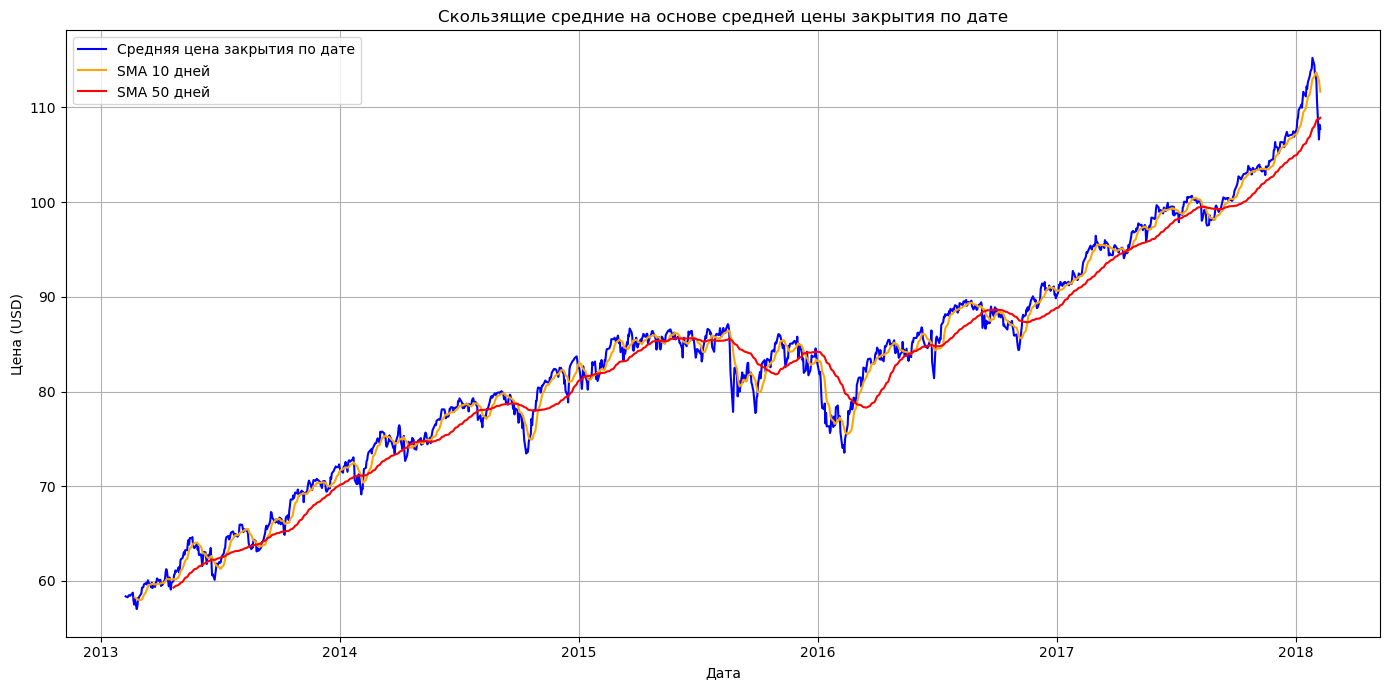

In [28]:
import matplotlib.pyplot as plt

pandas_df2=pandas_df

# 1. Усреднение цены закрытия по датам (по всем компаниям)
daily_avg_close = pandas_df2.groupby('date')['close'].mean().reset_index()

# 2. Расчёт скользящих средних (SMA_10 и SMA_50)
daily_avg_close['SMA_10'] = daily_avg_close['close'].rolling(window=10).mean()
daily_avg_close['SMA_50'] = daily_avg_close['close'].rolling(window=50).mean()

# 3. Построение графика
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_close['date'], daily_avg_close['close'], label='Средняя цена закрытия по дате', color='blue')
plt.plot(daily_avg_close['date'], daily_avg_close['SMA_10'], label='SMA 10 дней', color='orange')
plt.plot(daily_avg_close['date'], daily_avg_close['SMA_50'], label='SMA 50 дней', color='red')

plt.title("Скользящие средние на основе средней цены закрытия по дате")
plt.xlabel("Дата")
plt.ylabel("Цена (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Тенденция цены закрытия указывает на восходящий тренд рынка или портфеля акций за 2013-2018 период. В целом наблюдается высокая волатильность рынка. В середине 2014 года: небольшое снижение цены. В начале 2016 года: более глубокая коррекция, где цена падает ниже 70 USD. Золотой Крест: в начале 2016 года, является бычьим сигналом , указывающим на переход рынка из медвежьего состояния в бычье. 2013–2014 годы : Рынок находится в фазе формирования тренда. SMA 10 дней и SMA 50 дней движутся близко друг к другу, что указывает на неопределённость . 2015–2016 годы : После золотого креста в начале 2016 года рынок становится более уверенным в восходящем тренде. SMA 10 дней и SMA 50 дней расходятся, что усиливает уверенность в тренде. 2017–2018 годы : Тренд продолжает расти, хотя в 2017 году наблюдаются коррекции. SMA 50 дней остаётся над уровнем поддержки, что подтверждает восходящий тренд.

In [29]:
numeric_df = pandas_df[['open', 'high', 'low', 'close', 'volume']]
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

            open      high       low     close    volume
open    1.000000  0.999939  0.999928  0.999872 -0.142705
high    0.999939  1.000000  0.999903  0.999936 -0.142316
low     0.999928  0.999903  1.000000  0.999939 -0.143240
close   0.999872  0.999936  0.999939  1.000000 -0.142802
volume -0.142705 -0.142316 -0.143240 -0.142802  1.000000


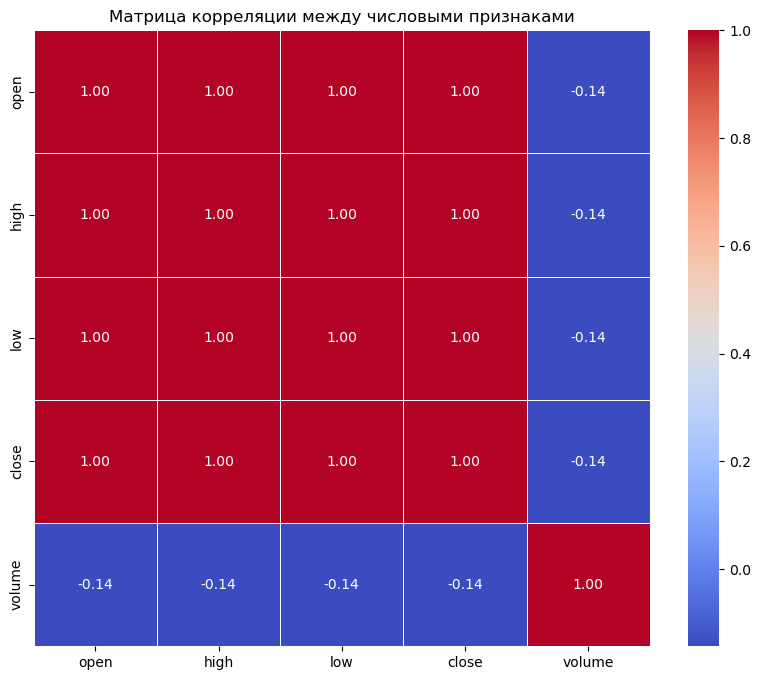

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title("Матрица корреляции между числовыми признаками")
plt.show()

In [31]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.0 MB/s eta 0:00:00a 0:00:01m


Положительная и высокая корреляция логична, High обычно больше Close и Open. Low обычно меньше Close и Open. Volume имеет небольшую отрицательную корреляцию (~-0.14) со всеми ценовыми признаками (Open, High, Low, Close). Чем дешевле цена, тем больше продаж.  Может быть связано с тем, что данные собраны за период, когда рыночная активность была стабильной, и объём торгов не сильно влиял на цены.

/tmp/ipykernel_4462/3288080266.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




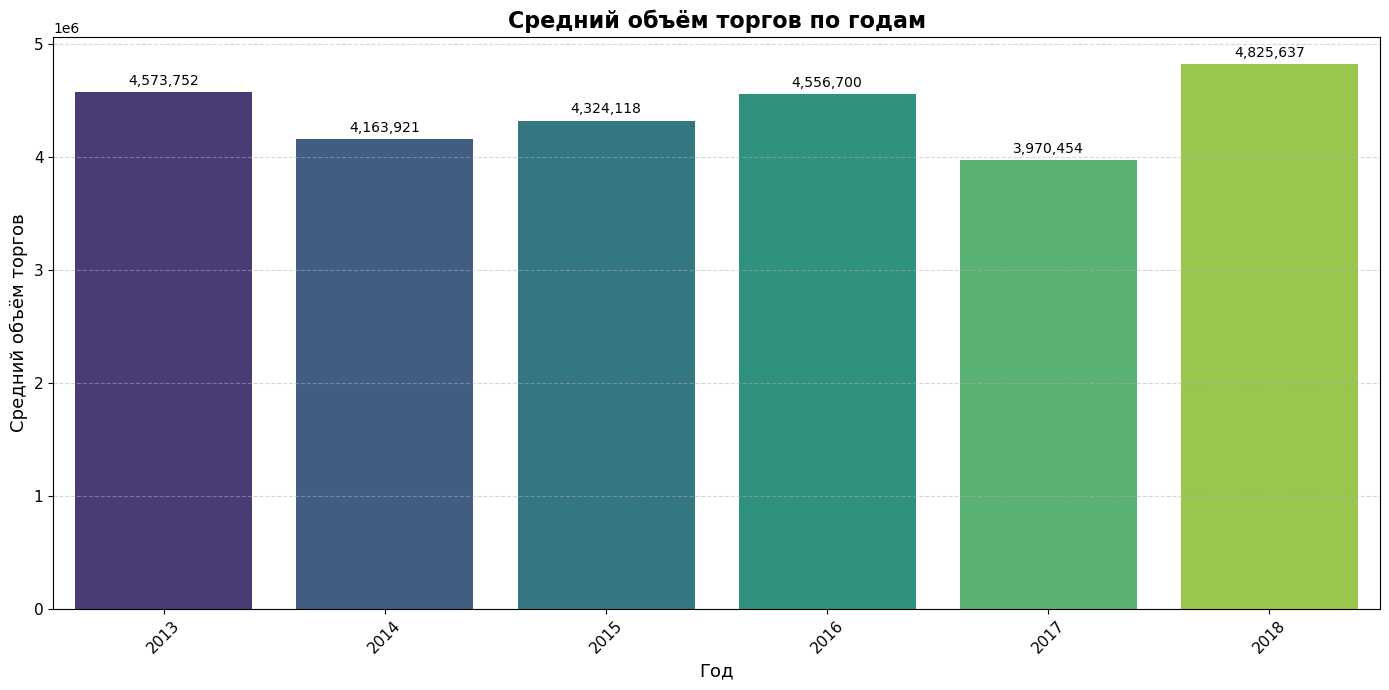

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Рассчитываем средний объём торгов по годам
volume_by_year = pandas_df.groupby('YEAR')['volume'].mean().reset_index()

# Переименовываем колонки для лучшей читаемости (опционально)
volume_by_year.columns = ['Год', 'Средний_Объем']

# Построение графика
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='Год', y='Средний_Объем', data=volume_by_year, palette='viridis')

# Добавляем подписи к столбцам
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height()):,}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     fontsize=10, color='black', xytext=(0, 8), 
                     textcoords='offset points')

# Настройка заголовков и подписей
plt.title("Средний объём торгов по годам", fontsize=16, fontweight='bold')
plt.xlabel("Год", fontsize=13)
plt.ylabel("Средний объём торгов", fontsize=13)

# Поворот меток по оси X
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# Сетка и отступы
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()

# Отображение графика
plt.show()

За весь период наблюдается небольшая волатильность , но общая тенденция указывает на стабильность с незначительными колебаниями.
Нет резких скачков или падений, что говорит о постоянном уровне рыночной активности. 
Наибольший объём торгов : Зарегистрирован в 2018 году (4,825,637).
Наименьший объём торгов : Зарегистрирован в 2017 году (3,970,454).
Максимальный рост : Произошёл между 2017 и 2018 годами (+21.5%).
Максимальное падение : Произошло между 2013 и 2014 годами (-8.5%).

Общие выводы:
1. Стабильность объёмов торгов с небольшой волатильностью:
Объём торгов акциями демонстрирует стабильную динамику на протяжении всего периода, без резких скачков или падений.
2. Восходящий тренд цены закрытия с высокой волатильностью:
За исследуемый период цена акций показала общий восходящий тренд. Несмотря на наличие коррекций (например, в середине 2014 года и начале 2016 года), рынок демонстрировал уверенное восстановление. Золотой крест в 2016 году стал важным сигналом перехода от медвежьего к бычьему рынку, после которого тренд стал более выраженным. SMA (средние скользящие) подтверждают усиление уверенности инвесторов с 2016 года.
3. Сезонность волатильности и доходности по дням недели:
Анализ показывает существование так называемого "понедельник-пятница эффекта": волатильность ниже в понедельник и пятницу, что делает эти дни потенциально более привлекательными для крупных сделок. При этом понедельник характеризуется отрицательной доходностью ("эффект понедельника"), вероятно, из-за влияния новостей за выходные. Максимальная волатильность приходится на середину недели, что может быть связано с публикацией макроэкономических данных и высоким уровнем деловой активности.
4. Постепенный рост цен и изменение волатильности во времени:
Медиана цены закрытия акций демонстрирует постепенный рост на протяжении всего периода.

In [35]:
# Преобразование Pandas DataFrame обратно в PySpark DataFrame
pandas_df_spark = spark.createDataFrame(pandas_df)

In [ ]:
# Путь в HDFS для сохранения
file_path_hdfs = "hdfs://localhost:9000/3_zadanie/hadoop/input/pandas_df_spark.csv"

# Сохранение DataFrame в формате CSV в HDFS
pandas_df_spark.write.csv(file_path_hdfs, header=True, mode='overwrite')